# Regularization

Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not big enough. Sure it does well on the training set, but the learned network **doesn't generalize to new examples** that it has never seen!

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement**: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 1** </u>: **Football field**<br> The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head </center></caption>


They give you the following 2D dataset from France's past 10 games.

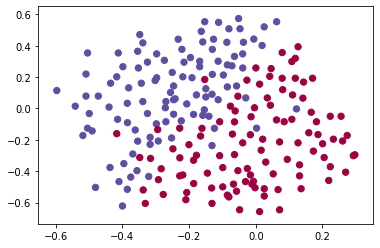

In [9]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Your goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

## Extra fun: Using Logistic Regression

Before we jump to neural network implementation with regularization, let's see how logistic regression would perform on such a dataset. I did logistic regression because the data seems linearly separable with low error  and is a binary classification problem.
Let's train the logistic regression on this data.

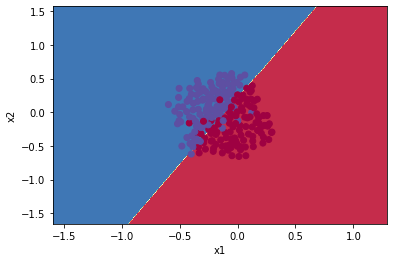

Accuracy of logistic regression: 92 % (percentage of correctly labelled datapoints)


In [18]:
#let's try logistic regression here first (train)
classifier = sklearn.linear_model.LogisticRegressionCV(cv = 3)
classifier.fit(train_X.T, train_Y.ravel().T)
plot_decision_boundary(lambda x: classifier.predict(x), train_X, train_Y)

# Print accuracy
LR_predictions = classifier.predict(train_X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(train_Y,LR_predictions) + np.dot(1-train_Y,1-LR_predictions))/float(train_Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

Logistic Regression Training Accuracy comes out to be 92% on this particular dataset. Let's see the testing accuracy and then we will move on to the regularized version of neural network implementation.

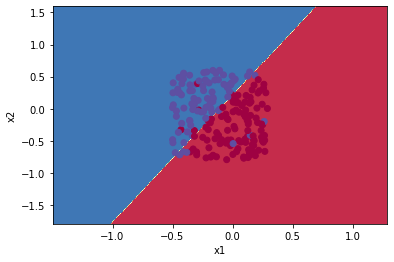

Accuracy of logistic regression: 93 % (percentage of correctly labelled datapoints)


In [19]:
#let's try logistic regression here first (train)
classifier = sklearn.linear_model.LogisticRegressionCV(cv = 3)
classifier.fit(train_X.T, train_Y.ravel().T)
plot_decision_boundary(lambda x: classifier.predict(x), test_X, test_Y)

# Print accuracy
LR_predictions = classifier.predict(test_X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(test_Y,LR_predictions) + np.dot(1-test_Y,1-LR_predictions))/float(test_Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

Logistic Regression Test Accuracy comes out to be 93% on this particular dataset. This model seems to have low variance and low bias. Let's move on to the neural network implementation. The one problem over here is that the decision boundary is linear, we want a non-linear decision boundary for our prediction task.

## 1 - Non-regularized model

You will use the following neural network (already implemented for you below). This model can be used:
- in *regularization mode* -- by setting the `lambd` input to a non-zero value. We use "`lambd`" instead of "`lambda`" because "`lambda`" is a reserved keyword in Python. 
- in *dropout mode* -- by setting the `keep_prob` to a value less than one

You will first try the model without any regularization. Then, you will implement:
- *L2 regularization* -- functions: "`compute_cost_with_regularization()`" and "`backward_propagation_with_regularization()`"
- *Dropout* -- functions: "`forward_propagation_with_dropout()`" and "`backward_propagation_with_dropout()`"

In each part, you will run this model with the correct inputs so that it calls the functions you've implemented. Take a look at the code below to familiarize yourself with the model.

In [20]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
    
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(0, num_iterations):
        
        #forward propagation
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        
        #Cost calculation
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        #back propagation
        assert(lambd==0 or keep_prob==1)
        
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        #update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Let's train the model without any regularization, and observe the accuracy on the train/test sets.

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724213
Cost after iteration 20000: 0.1385164242326018


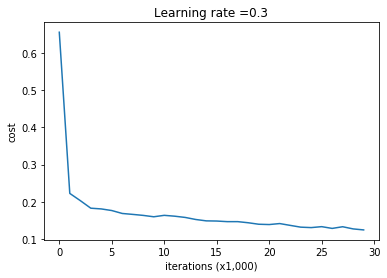

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [21]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the **baseline model** (you will observe the impact of regularization on this model). Run the following code to plot the decision boundary of your model.
(Note: this performs worse than the far less complex logistic regression we performed earlier)